In [1]:
import cbgt

'0.0.3'

In [2]:
import cbgt.netgen as ng
import cbgt.analyzefx as afx
from cbgt import vis, sim
from subprocess import call, Popen
from safaribook import safariplot as splot
from time import sleep
import random
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")

splot.style(theme='safari-day', grid=True, spines=True, fscale=1.4, figsize=(6., 3.5))
roundRT = lambda x, ndec: int(round(float(str(x)[:5]), ndec)*1000)
zscore_series = lambda s: (s - s.mean()) / s.std()
normalize_series = lambda s: (s - s.min()) / (s.max() - s.min())

clrs = ['#347fff', '#febe08']
eclrs = ['#1657de', '#f5a005']
bdf = pd.read_csv("/Users/kyle/demo_cbgt_bdf.csv")

## Global Params

In [3]:
parentDir = 'cbgtDemoTEST'
savedir = os.path.join(os.path.expanduser('~'), parentDir)
if not os.path.isdir(savedir):
    os.mkdir(savedir)

BaseStim = 0
Stim = 2.54
Dynamic = 30.0
Choices = 2
rampingCTX = True
popscale = .3
Start=200


presetLow = ng.set_post_learning_weights(dMSN=[1.01, 0.99], iMSN=[1.0,1.0])
presetHi = ng.set_post_learning_weights(dMSN=[1.03, 0.98], iMSN=[1.0,1.0])
presets = [presetLow, presetHi]

conds = ['low', 'high']
condABC = ['a', 'b']
cond12 = [1, 2]

savedirs = [os.path.join(savedir, c) for c in conds]
saveLow, saveHi = savedirs
saveTest=os.path.join(savedir, 'test')

presetDict = dict(zip(conds, presets))
condOrder = dict(zip(conds, condABC))
condLevel = dict(zip(conds+['test'], cond12+[0]))

# Efficacy sampling f(x) for individual networks

In [4]:
def get_sampling_params(scale=.05):
    
    CxSTR      =    0.2
    CxTh       =    0.03
    CxFSI      =    0.165
    D1STR_GPi  =    1.10 #1.07
    D2STR_GPeP =    1.65
    STN_GPeP_A =    0.07
    STN_GPeP_N =    4.01
    STN_GPi    =    0.0324
    GPi_Th     =    0.067
    ThSTR      =    0.34
    ThCx       =    0.02

    mu = dict(Cx={'STR':CxSTR, 'Th':CxTh, 'FSI':CxFSI}, 
                Th={'STR':ThSTR, 'Cx':ThCx},
                D1STR={'GPi': D1STR_GPi},
                D2STR={'GPeP': D2STR_GPeP},
                STN={'GPi': STN_GPi},
                GPi={'Th': GPi_Th})
    sd = {i:{j: mu[i][j]*scale for j in list(mu[i])} for i in list(mu)}
    return mu, sd


def sample_network_efficacies(muEff, sdEff, N):
    X = {}
    nuclei = list(muEff)
    for i in nuclei:
        targets = list(muEff[i])
        X[i] = {}
        for j in targets:
            X[i][j] = np.random.normal(muEff[i][j], sdEff[i][j], N)
    return X


def build_single_network(X, idx=0):
    
    Cx={'STR': X['Cx']['STR'][idx], 
        'Th': X['Cx']['Th'][idx], 
        'FSI': X['Cx']['FSI'][idx]}
    
    D1STR={'GPi': X['D1STR']['GPi'][idx]}
    D2STR={'GPeP': X['D2STR']['GPeP'][idx]}
    
    STN={'GPi': X['STN']['GPi'][idx]}
    
    GPi={'Th': X['GPi']['Th'][idx]}
    
    Th={'STR': X['Th']['STR'][idx], 
        'Cx': X['Th']['Cx'][idx]}

    return ng.getConEff(Cx=Cx, D1STR=D1STR, D2STR=D2STR, STN=STN, GPi=GPi, Th=Th)

# Sample 5 individual networks

In [5]:
N_subj = 3
sdScale = .05

conProb = ng.getConProb()
muEff, sdEff = get_sampling_params(sdScale)
X = sample_network_efficacies(muEff, sdEff, N=N_subj)
subj_eff_dicts = [build_single_network(X, idx=i) for i in range(N_subj)]

# Simulate example trial

In [8]:
# get conn. efficacies for 1st subject network (idx=0)
idx = 0
conEff_i = subj_eff_dicts[idx]

# set stimulus strength
stim = 2.5
# get preset for "high" reward condition
# (e.g., Cx-dMSN weight scalars)
preset = presetDict['high']

# set save directory
ng.setDirectory(saveTest)

# configure trial and network parameters
np.random.seed(seed=np.random.randint(0,1000))
sweepcount = ng.configureSweep(0, experiment='mc', preset=preset, Start=Start,
                               popscale=popscale, BaseStim=BaseStim, Choices=Choices, 
                               WrongStim=stim, RightStim=stim, Dynamic=Dynamic,
                               rampingCTX=True,
                               conProb=conProb, 
                               conEff=conEff_i)

# compile current configuration and simulate trial
ng.compileAndRunSweepALL(1, 0, 1)

# Plot population firing rates

RT:	455.01ms
Acc:	Correct



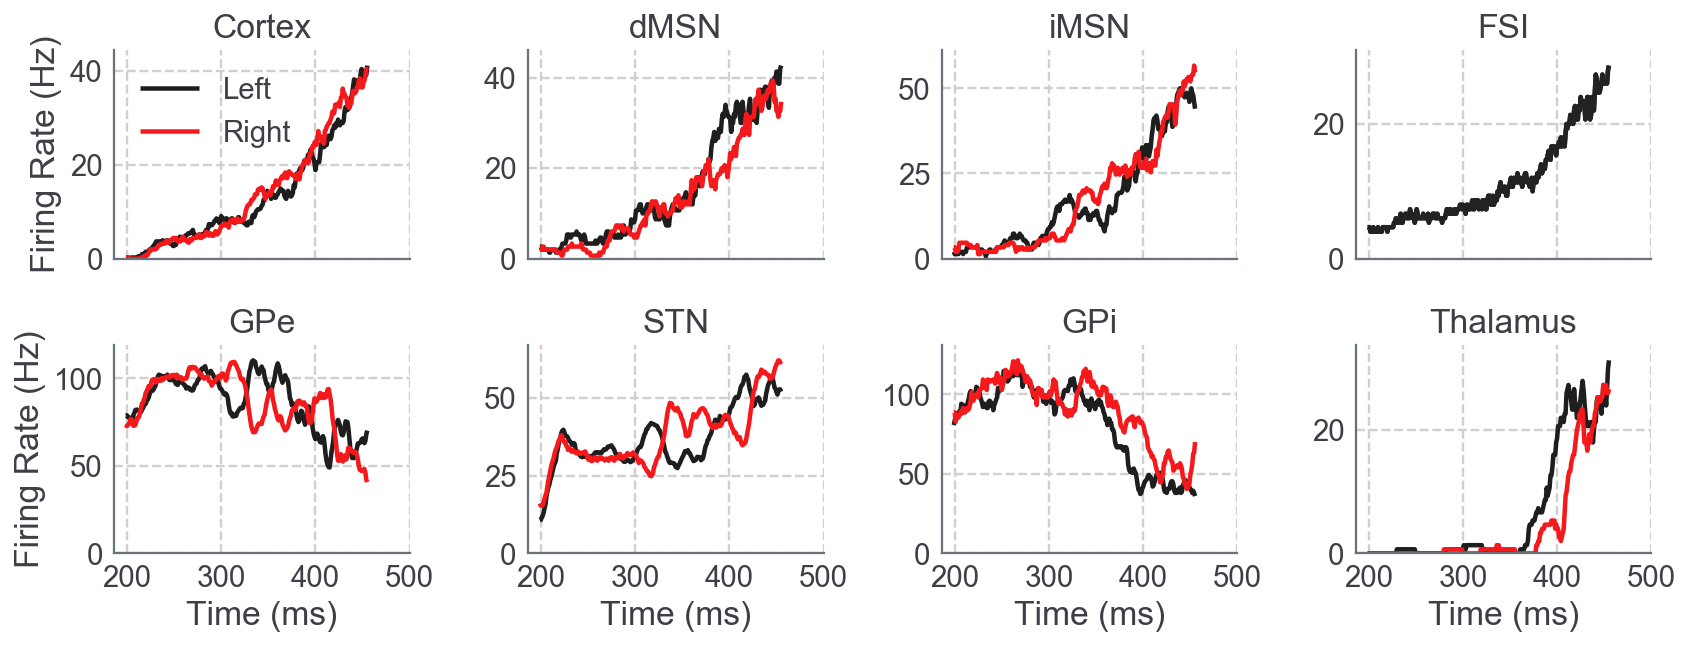

In [9]:
vis.plot_trial_rates(t=0)

# Sample stimulus intensity across trials

2.523400828756478


True

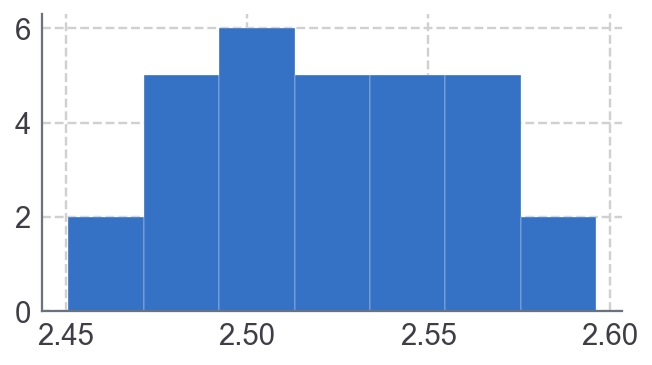

In [13]:
ntrials = 30
stimArray = vis.plot_stim_dist(mu=2.5, sd=.075, clip=(2.45, 2.6), ntrials=ntrials, bins=7) 
print(stimArray.mean())
ntrials == stimArray.size

# Simulate full dataset
* 5 sampled CBGT networks
* 3 conditions (Low, Medium, and High reward)
* 20 trials / condition (see cell above)

In [16]:
bdf_list, rdf_list, ardf_list  = [], [], []
msn_idx_list, msn_cond_list = [], []
msn_pops = ['dMSN0', 'dMSN1', 'iMSN0', 'iMSN1']

for cond_ix, cond in enumerate(conds):
    
    bdf_list_c, rdf_list_c, ardf_list_c = [], [], []
    preset_c = presets[cond_ix]
    
    savedir_c = savedirs[cond_ix]
    if not os.path.isdir(savedir_c):
        os.mkdir(savedir_c)
    
    for i, subject_eff in enumerate(subj_eff_dicts):
        
        savedir_ci = os.path.join(savedir_c, str(i)) 
        if not os.path.isdir(savedir_ci):
            os.mkdir(savedir_ci)
            
        res_ci = sim.run_cbgt_sweeps(stimArray, preset=preset_c, 
                                    rampingCTX=True, savedir=savedir_ci, 
                                    cond=cond, ntrials=ntrials, Start=Start, 
                                    popscale=popscale, BaseStim=BaseStim, 
                                    Dynamic=Dynamic, Choices=Choices, 
                                    conEff=subject_eff, conProb=conProb)

        bdf_ci = afx.analyze_network_behavior(res_ci, preset_c, 
                                              stimArray, cond, 
                                              savedir_ci, idx=i,
                                              conEff=subject_eff)

        ratedf_ci, avg_ratedf_ci = vis.save_and_plot(res_ci, bdf_ci, 
                                                    cond=cond, idx=i, 
                                                    savedir=savedir_ci, 
                                                    window=None, Start=Start, 
                                                    trials=[1], getdfs=True)
        
        vis.plot_cond_rtdist(bdf_ci, bins=8, 
                             cond=cond, outdir=savedir_ci, 
                             norm_hist=False)
        vis.plot_cor_err_rts(bdf_ci, bins=8, 
                             outdir=savedir_ci, 
                             norm_hist=False)
        plt.close('all')
        
        msnDF = ratedf_ci[ratedf_ci.population.isin(msn_pops)].reset_index(drop=True)
        msnDF_fname = 'msnRates_allTrials_{}_idx{}.csv'.format(cond, i)
        msnDF.to_csv(os.path.join(savedir_ci, msnDF_fname), index=False)

        bdf_list_c.append(bdf_ci)
        rdf_list_c.append(ratedf_ci)
        ardf_list_c.append(avg_ratedf_ci)
        msn_idx_list.append(msnDF)
        
    bdf_list.append(pd.concat(bdf_list_c).reset_index(drop=True))
    rdf_list.append(pd.concat(rdf_list_c).reset_index(drop=True))
    ardf_list.append(pd.concat(ardf_list_c).reset_index(drop=True))
    msn_cond_list.append(pd.concat(msn_idx_list).reset_index(drop=True))

msnAll = pd.concat(msn_cond_list).reset_index(drop=True)
bdf = pd.concat(bdf_list).reset_index(drop=True)
ratedf = pd.concat(rdf_list).reset_index(drop=True)
ardf = pd.concat(ardf_list).reset_index(drop=True)

Cond: LOW
	Mean CorRT:	394.01 (28.78)
	Med CorRT:	371.00
	Avg ErrRT:	394.38 (31.60)
	P(Left):	0.6522
Cond: LOW
	Mean CorRT:	470.46 (31.01)
	Med CorRT:	453.01
	Avg ErrRT:	483.01 (194.32)
	P(Left):	0.8696
Cond: LOW
	Mean CorRT:	407.24 (24.69)
	Med CorRT:	396.01
	Avg ErrRT:	417.01 (34.86)
	P(Left):	0.7391
Cond: HIGH
	Mean CorRT:	388.96 (21.92)
	Med CorRT:	371.00
	Avg ErrRT:	400.51 (79.00)
	P(Left):	0.9130
Cond: HIGH
	Mean CorRT:	449.55 (25.58)
	Med CorRT:	421.01
	Avg ErrRT:	999.99 (0.00)
	P(Left):	1.0000
Cond: HIGH
	Mean CorRT:	408.37 (22.47)
	Med CorRT:	394.01
	Avg ErrRT:	410.01 (74.00)
	P(Left):	0.9167


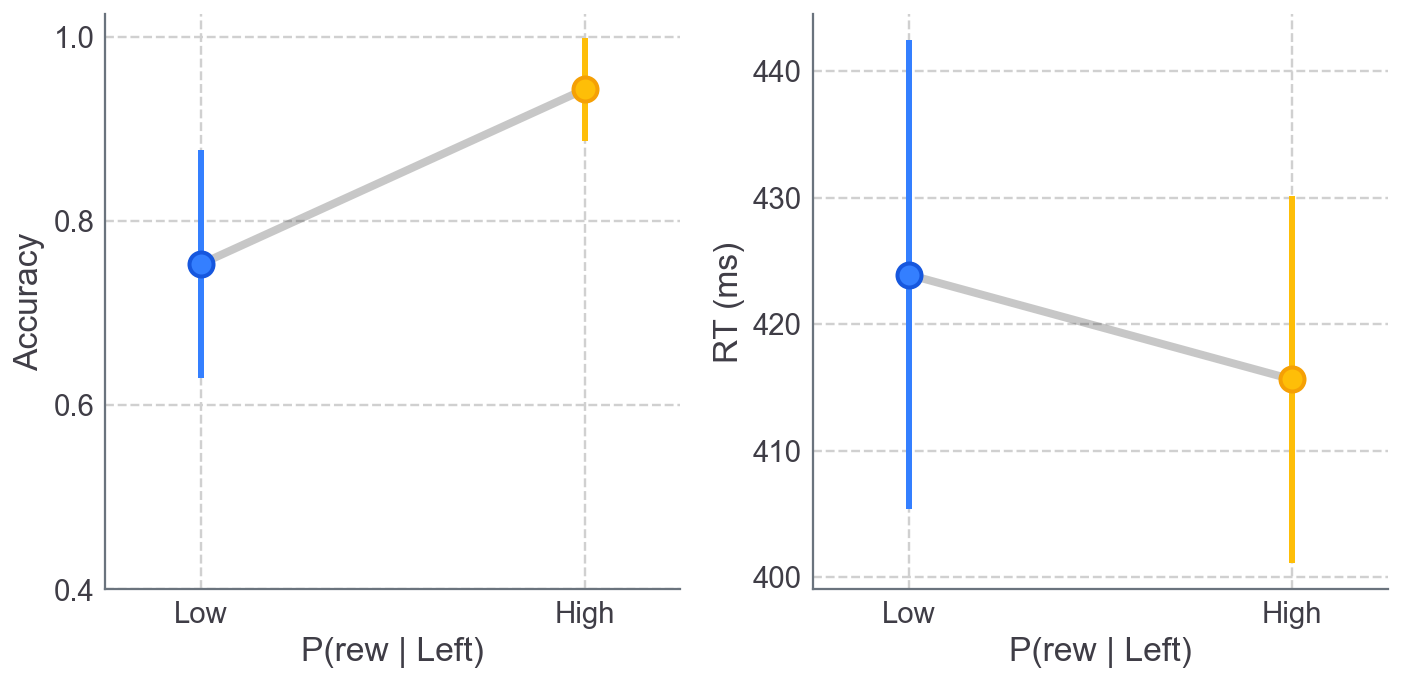

In [28]:
vis.plot_mean_acc_rt(bdf, conds=conds, subject_mean=True, clrs=clrs, eclrs=eclrs)

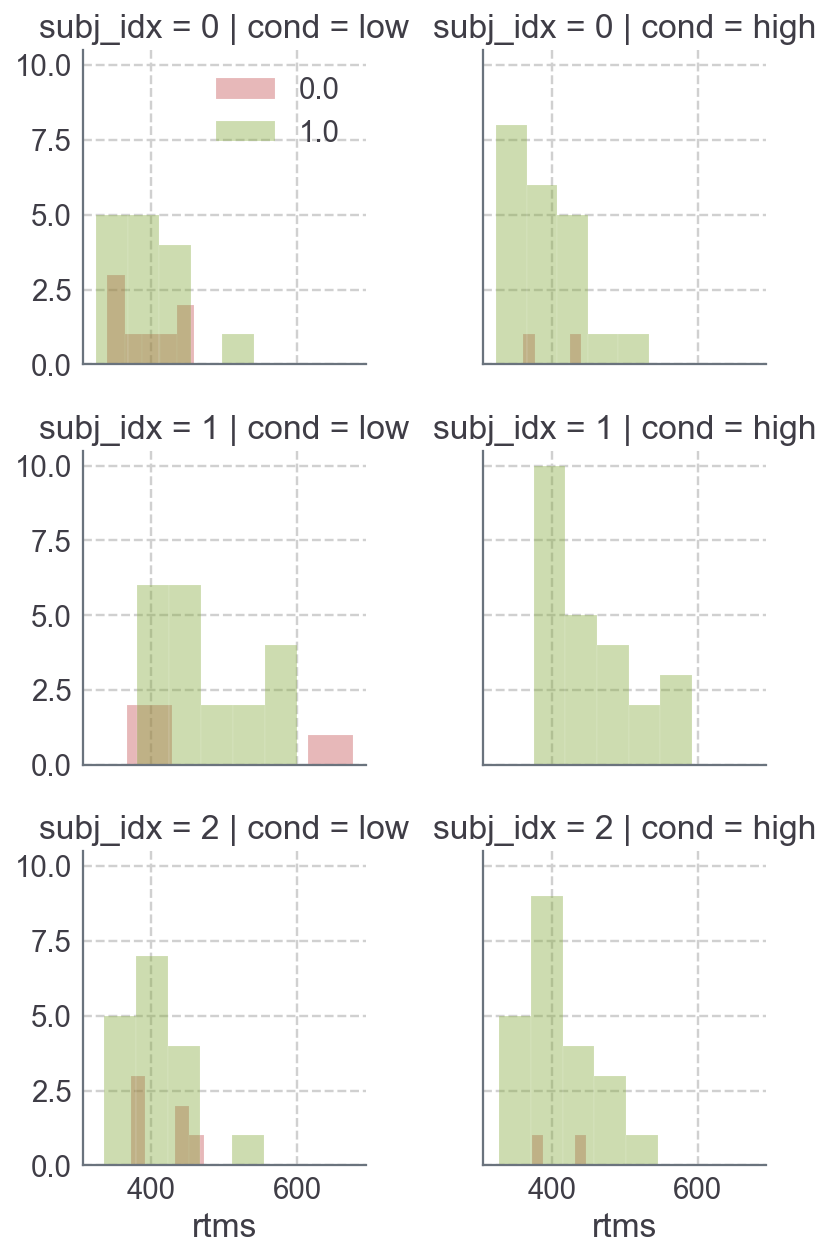

In [29]:
bdfx = bdf[bdf.acc.isin([0,1])]
gf=sns.FacetGrid(bdfx, hue='acc', row='subj_idx', col='cond', palette={0:'r', 1:'g'}, legend_out=False)
gf.map(sns.distplot, 'rtms', bins=5, kde=False, hist=True, kde_kws=dict(bw=1, shade=True))
gf.axes[0,0].legend()
plt.tight_layout()

In [30]:
bdf = afx.get_cbgt_covariates(bdf, msnAll, conds=conds)
bdf = afx.norm_covariates(bdf.dropna())

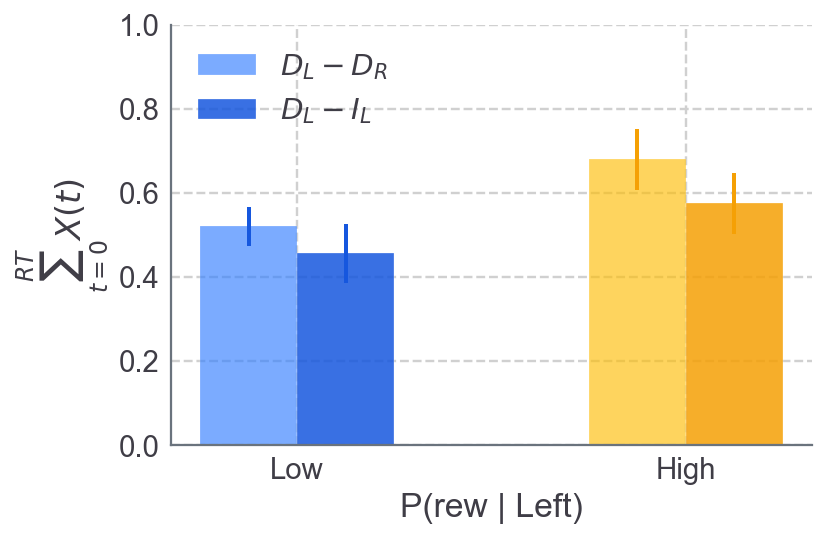

In [31]:
vis.plot_striatal_regressors(bdf, msn_type='d', subject_mean=True, conds=conds, clrs=clrs, eclrs=eclrs)

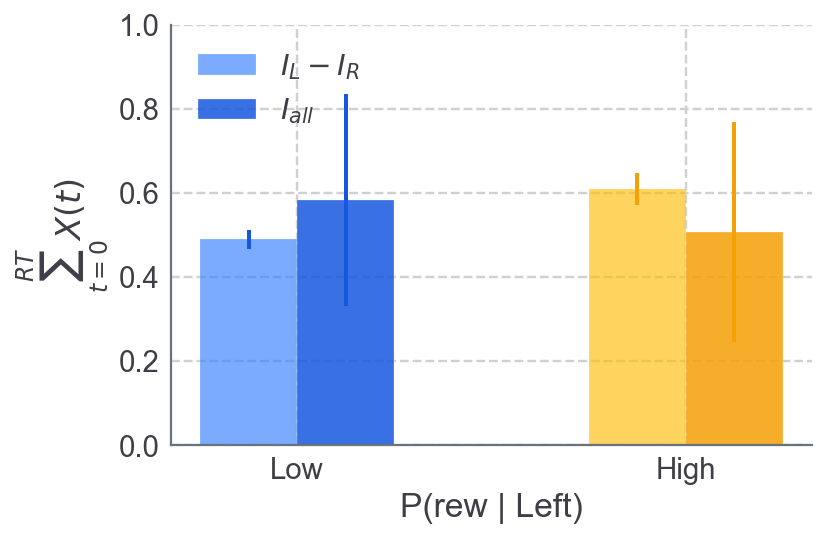

In [32]:
vis.plot_striatal_regressors(bdf, msn_type='i', subject_mean=True, conds=conds, clrs=clrs, eclrs=eclrs)

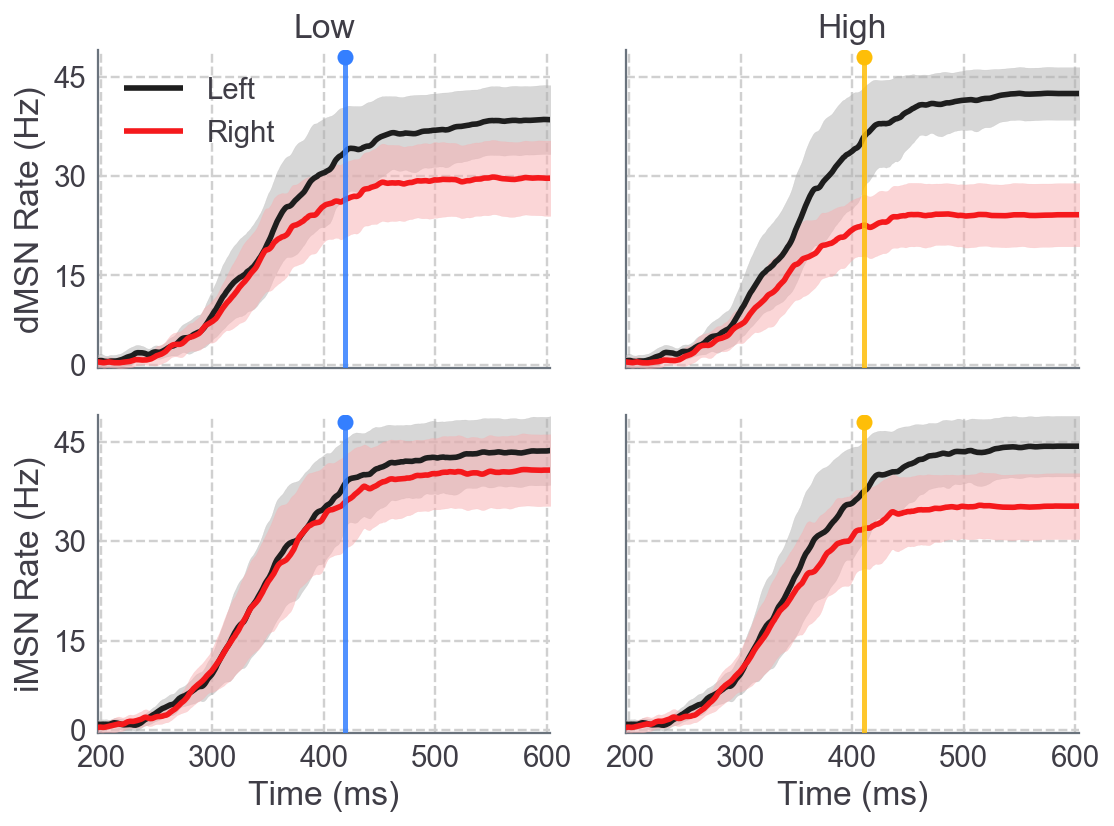

In [33]:
msnPad = msnAll.fillna(method='pad', axis=1).convert_objects(convert_numeric=True)
msnDFs = [msnPad[msnPad.population==pop].reset_index(drop=True) for pop in msn_pops]
ys, ysErr = afx.get_avgMSN_traces(msnDFs, window=5)
vis.plot_average_msn_rates(ys, ysErr, bdf, ntime=600, ymax=48, lw=2.8, plotRT=True, conds=conds, clrs=clrs, eclrs=eclrs)

In [5]:
def save_hddm_params(m, hddm_savedir, mname='va'):

    mname = '{}_stats'.format(mname)
    
    if not os.path.exists(hddm_savedir):
        os.mkdir(hddm_savedir)
    
    m.print_stats(os.path.join(hddm_savedir, '{}.txt'.format(mname)))
    statdf = m.gen_stats()
    statdf = statdf.reset_index()
    statdf = statdf.rename(columns={'index': 'param'})
    statdf.to_csv(os.path.join(hddm_savedir, '{}_df.csv'.format(mname)))

In [4]:
import hddm
hddm_savedir = os.path.join(os.path.expanduser('~'), 'hddm_fits')

data = bdf.reset_index(drop=True)
bias = True
inform = True
incl = ['z']
dependsCol = 'level'
nsamples = 2500
nburn = 1000

nullm = hddm.HDDM(data, bias=bias, include=incl, informative=inform)

freep = ['a', 't', 'v', 'z', 'va', 'vt', 'vz']
models = {}
for p in freep:
    plist = list(p)
    nfree = len(plist)
    depends = dict(zip(plist, [dependsCol]*nfree))
    m = hddm.HDDM(data, depends_on=depends, bias=bias, 
                  include=incl, informative=inform)
    models[p] = m

In [6]:
nullm.sample(nsamples, burn=nburn)
save_hddm_params(nullm, hddm_savedir, 'null')
nullm.dic_info

 [-----------------100%-----------------] 500 of 500 complete in 8.0 sec

{'DIC': -300.33993876360842,
 'deviance': -308.8700764342064,
 'pD': 8.5301376705979806}

In [11]:
dics = []
for mname in freep:
    m = models[mname]
    m.sample(nsamples, burn=nburn)
    save_hddm_params(m, hddm_savedir, mname)
    dics.append(m.dic)

 [-----------------100%-----------------] 2500 of 2500 complete in 69.0 sec

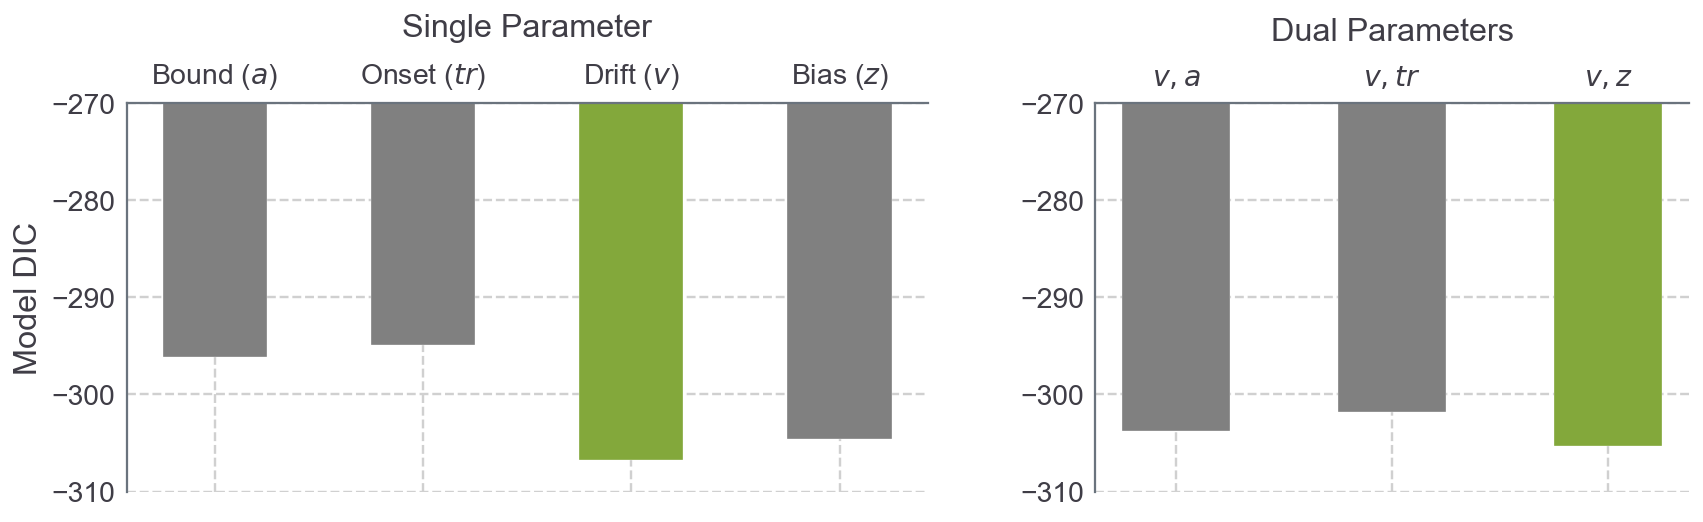

In [28]:
splot.style(figsize=(14,5))
freep = ['a', 't', 'v', 'z', 'va', 'vt', 'vz']
singles = [models[mname] for mname in freep[:4]]
duals = [models[mname] for mname in freep[4:]]
dics1 = dics[:4]
dics2 = dics[4:]
bestSingle = np.argmin(dics1)
bestDual = np.argmin(dics2)

# uncomment for delta DIC
# dics1 = [mm.dic - nullm.dic for mm in singles]
# dics2 = [mm.dic - nullm.dic for mm in duals]

lbls1 = ['Bound ($a$)','Onset ($tr$)','Drift ($v$)','Bias ($z$)']
lbls2 = ['$v,a$', '$v,tr$', '$v,z$']
clrs1 = ['Gray']*4
clrs2 = ['Gray']*3
clrs1[bestSingle] = 'g'
clrs2[bestDual] = 'g'

import matplotlib.gridspec as gridspec
f = plt.figure(figsize=(14,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.35,1], wspace=.24, top=.8)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

_ = ax1.bar(np.arange(4), dics1, color=clrs1, width=.5)
_ = ax2.bar(np.arange(3), dics2, color=clrs2, width=.5)
ax1.set_xticks(np.arange(4))
ax2.set_xticks(np.arange(3))
ax1.set_xticklabels(lbls1)
ax2.set_xticklabels(lbls2)

ymax = np.round(np.max(dics)*.0001, 2)*10000 + 30
ymin = np.round(np.min(dics)*.0001, 2)*10000 - 10
for ax in [ax1,ax2]:
    #ax.set_ylim(-11000, -12500)
    #ax.set_yticks([-11000, -11500, -12000, -12500][::-1])
    #ax.set_ylim(-0, -1350)
    #ax.set_yticks(np.linspace(0, -1300,5).astype(int)[::-1])
    ax.set_ylim(ymax, ymin)
    ax.invert_yaxis()
    ax.xaxis.set_label_position("top")
    sns.despine(top=False,bottom=True,ax=ax)

ax1.set_ylabel('Model DIC')
# ax1.set_ylabel('$\Delta$ DIC')
ax1.set_xlabel('Single Parameter', labelpad=12)
ax2.set_xlabel('Dual Parameters', labelpad=12)
plt.tight_layout()
# fname = os.path.join(savedir, 'hddm/modelDICs.png')
# plt.savefig(fname, dpi=600)

In [7]:
import itertools
Xs = ['nD_lrdiff_sum', 'nDI_ldiff_sum', 'nI_LR_mean']
combos = [list(s) for s in list(itertools.combinations(Xs, 2))]
formulas = [["v ~ {}:C(level)".format(X1), 'a ~ {}:C(level)'.format(X2)] for (X1, X2) in combos]

In [ ]:
data = bdf.reset_index(drop=True)
interact = True
group_reg = True
bias = False

incl=['z']
bias=True
    
model_ids = np.arange(1, N+1)
models = {}
for mID in model_ids:
    reg_formula = formulas[mID]
    models[mID] = hddm.HDDMRegressor(data, reg_formula, bias=bias, include=incl, 
                                     keep_regressor_trace=True, 
                                     group_only_regressors=group_reg)

In [ ]:
for mID in model_ids:

    print('\nModel ID: {}\n'.format(mID))
    
    m = models[mID]
    m.sample(2000, burn=1200)
    statdf = m.gen_stats()
    finfo = m.dic_info
    dic, deviance, pD = finfo['DIC'], finfo['deviance'], finfo['pD']
    print('\nM{} DIC: {}'.format(mID, int(dic)))

    reg1, reg2 = formulas[mID]
    param_reg = {reg1.split(' ~ ')[0]: reg1.split(' ~ ')[1].split(':')[0], 
                 reg2.split(' ~ ')[0]: reg2.split(' ~ ')[1].split(':')[0]}
    pdicts.append(param_reg)
    
    statdf['modelID'] = mID
    statdf['DIC'] = dic
    statdf['deviance'] = deviance
    statdf['pD'] = pD
    statdf = statdf.reset_index()
    statdf = statdf.rename(columns={'index':'param'})
    statdf = split_param_col(statdf, param_reg)
    statdfs.append(statdf)
    
    p1,p2 = np.sort(list(param_reg))
    r1,r2 = np.array([param_reg[p] for p in [p1,p2]])
    
    simdf = simulate_hddmRegression_data(m, param_reg, interaction=interact, ntrials=10, nsamples=200)
    simdf['modelID'] = mID
    simdf['DIC'] = dic
    
    simdf2 = filter_data(simdf, sd=3.5, cutoff=1100)
    plot_mean_acc_rt(simdf2)
    plt.savefig('BEHAVIOR_{}~{}__{}~{}.png'.format(p1,r1,p2,r2), dpi=500)
    simdfs.append(simdf2)

    tracedf = get_hierarchical_regressor_traces(data, param_reg, reg_values=False)
    tracedf['modelID'] = mID
    tracedf.to_csv('TRACES_{}~{}__{}~{}.csv'.format(p1,r1,p2,r2), index=False)
    traces.append(tracedf)

    tracedfx = tracedf[tracedf.bound<=(tracedf.bound.mean() + tracedf.bound.std())]
    plot_hierarchical_regressor_traces(tracedfx, bw=.1)
    plt.savefig('POSTERIORS_{}~{}__{}~{}.png'.format(p1,r1,p2,r2), dpi=500)
    
    plot_rtdist_fits(data, simdf2)
    plt.savefig('RTdistFits_{}~{}__{}~{}.png'.format(p1,r1,p2,r2), dpi=500)
    plt.close('all')

    tracesAll = pd.concat(traces)
    tracesAll.to_csv('traces_all.csv', index=False)
    simdfAll = pd.concat(simdfs)
    simdfAll.to_csv('simdf_all.csv', index=False)
    statdfAll = pd.concat(statdfs).reset_index(drop=True)
    statdfAll.to_csv('statdf_all.csv', index=False)